In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

## Machine learning

In [4]:
from implementations import *

### Data pre-processing 

In [5]:
# putting the meaningless values to the median of the column
tX = np.where(tX==-999., np.nan,tX)
med_X = np.nanmedian(tX, axis=0)

inds = np.where(np.isnan(tX))
tX[inds] = np.take(med_X, inds[1])

In [6]:
print(np.where(tX[0] == 2))

(array([22], dtype=int64),)


In [40]:
# remove categorical data and standarize the rest
tX = np.delete(tX, 22, axis=1)
tX = np.apply_along_axis(standardize, 1, tX)

y = y[0:10000]
tX = tX[0:10000, :]

### Exploratory analysis

### Feature processing

**Least squares**

In [8]:
(w_ls, loss_ls) = least_squares(y, tX)

print("w* ={w}\n\nmse={loss}".format(
    w=w_ls, loss=loss_ls))

w* =[ -3.53727731  -4.06854073  -4.16663232  -3.48872393 -24.24432581
  -3.37137256  -4.25577128  18.55480819  -3.71331282   0.53078708
 -22.30290066  -0.47004864  19.11840818  -7.0075991   -3.62919546
  -3.44682342  -6.66461348  -3.41384647  -3.61066868  -3.37946375
  -3.39566931  -3.63802668  -3.6875801   -3.43289319  -3.71330003
  -4.75191082  -3.19589595  -3.73115076  -7.68813543]

mse=0.3339267354817032


**Least squares with Gradient Descent**

In [9]:
#define parameters

initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_gd = []
ws_gd = []
for gamma in gammas:
    (w, loss) = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    losses_gd.append(loss)
    ws_gd.append(w)

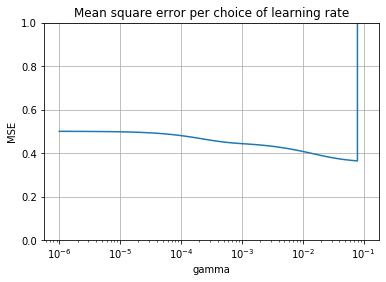

In [10]:
#plot the losses per gamma

fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [11]:
idx = np.nanargmin(losses_gd)

loss_gd = losses_gd[idx]
w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=loss_gd, gamma=gamma_gd ))

w* =[ 0.03851654 -0.53783115 -0.03842045  0.12218766  0.03448255  0.06755577
  0.03154606  0.03822666 -0.05576876  0.0608678   0.02292952  0.0514188
  0.03738246  0.25674693  0.03698962  0.03774248 -0.08602675  0.03754928
  0.03718121 -0.06675893  0.03866296 -0.066096   -0.07702633  0.0378272
  0.03732568 -0.13743116  0.03822707  0.03714195 -0.03514865]

mse=0.3637547214432508

gamma=0.07906043210907701


**Least squares with Stochastic Gradient Descent**

In [12]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_sgd = []
ws_sgd = []
for gamma in gammas:
    (w, loss) = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
    losses_sgd.append(loss)
    ws_sgd.append(w)

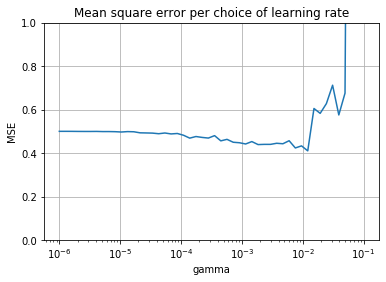

In [13]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [14]:
idx = np.nanargmin(losses_sgd)

loss_sgd = losses_sgd[idx]
w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=loss_sgd, gamma=gamma_sgd ))

w* =[-0.03257081 -0.26288478 -0.03614423  0.02743359  0.02596356  0.10398397
  0.02229303  0.02656272 -0.02392391  0.00456352  0.02042357  0.02882786
  0.02633165  0.09372461  0.02514278  0.02287683 -0.06445987  0.02824218
  0.03134112 -0.05797693  0.02473977 -0.15527382 -0.00243047  0.02530211
  0.02789265 -0.01174774  0.02799199  0.02569894  0.02807609]

mse=0.40993926991935564

gamma=0.012067926406393288


**Ridge regression**

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation and bias-variance decomposition respectively. 

As the two are interdependent, we can just run them in a loop (each cells after the others, so first the cross-validation, then biais-variance decomposition, again cross-validation, etc.) to have the best parameters. 

***Cross-validation hyperparameter selection***

In [29]:
def cross_validation_visualization(lambds, loss_tr, loss_te):
    """visualization the curves of train error and test error."""
    plt.semilogx(lambds, loss_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, loss_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("error")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)

In [16]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-15, -1, 50)
ratio_train = 0.7
seeds = range(20)
degrees = range(0, 20)

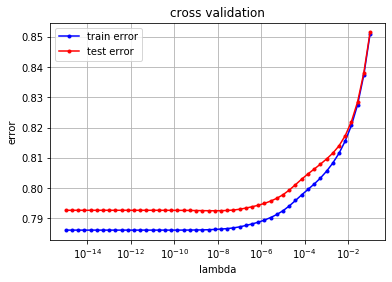

In [22]:
k_indices = build_k_indices(y, k_fold, seed)
rmse_tr_cv = []
rmse_te_cv = []

for lambda_ in  lambdas:
    l_rmse_tr = []
    l_rmse_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(y, tX, k_indices, k, lambda_, degree_ri)
        l_rmse_tr.append(np.sqrt(2*loss_tr))
        l_rmse_te.append(np.sqrt(2*loss_te))
    rmse_tr_cv.append(np.mean(l_rmse_tr))
    rmse_te_cv.append(np.mean(l_rmse_te))
cross_validation_visualization(lambdas, rmse_tr_cv, rmse_te_cv)

In [23]:
idx = np.nanargmin(rmse_te_cv)
lambda_ri = lambdas[idx]

print("lambda* ={lambda_}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, rmse_tr=rmse_tr_cv[idx], rmse_te=rmse_te_cv[idx]))

lambda* =7.1968567300115284e-09

rmse train=0.7863795103953879

rmse test=0.7925455580691279


***Bias-variance decomposition for complexity determination***

In [30]:
def bias_variance_decomposition_visualization(degrees, loss_tr, loss_te):
    """visualize the bias variance decomposition."""
    loss_tr_mean = np.expand_dims(np.mean(loss_tr, axis=0), axis=0)
    loss_te_mean = np.expand_dims(np.mean(loss_te, axis=0), axis=0)
    plt.plot(degrees, loss_tr.T, 'b', linestyle="-", label='train', linewidth=0.3)
    plt.plot(degrees, loss_te.T, 'r', linestyle="-", label='test', linewidth=0.3)
    plt.plot(degrees, loss_tr_mean.T, 'b', linestyle="-", label='train', linewidth=3)
    plt.plot(degrees, loss_te_mean.T, 'r', linestyle="-", label='test', linewidth=3)
    plt.ylim(0, 5)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")

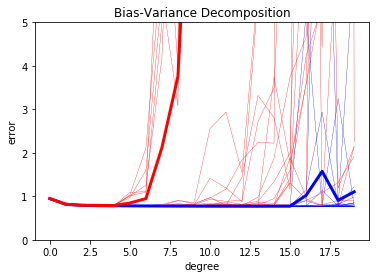

In [25]:
rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        
        
    mse_tr = []
    mse_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_tr))
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_te))

bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

In [26]:
rmse_te_bv = np.array(rmse_te_bv)
rmse_tr_bv = np.array(rmse_tr_bv)

idx = np.nanargmin(np.mean(rmse_te_bv-rmse_tr_bv, axis=1))

degree_ri = degrees[idx]

print("degree* ={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    degree=degree_ri, rmse_tr=rmse_tr_bv[idx].mean(), rmse_te=rmse_te_bv[idx].mean()))

degree* =3

rmse train=0.7867499200221995

rmse test=0.8067776475439661


**Logistic regression**

In [41]:
y = np.where(y==-1, 0, y)
print(y)

initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-20, -2, 50)

[1. 0. 0. ... 0. 0. 0.]


In [28]:
losses_lr = []
ws_lr = []
for gamma in gammas:
    (w, loss) = logistic_regression(y, tX, initial_w, max_iters, gamma)
    losses_lr.append(loss)
    ws_lr.append(w)

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:54: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


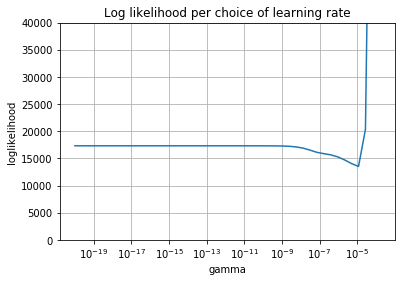

In [29]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
ax.set_ylim([0, 40000])
plt.show()

In [30]:
idx = np.nanargmin(losses_lr)

loss_lr = losses_lr[idx]
w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=loss_lr, gamma = gamma_lr))

w* =[ 0.06714641 -1.23979758 -0.06038992  0.27586738  0.08110942  0.14549053
  0.07464946  0.08854599 -0.10121924  0.1085217   0.05622116  0.11493719
  0.08640316  0.51608573  0.08563761  0.08717642 -0.2114878   0.08674829
  0.08590917 -0.21943247  0.08918982 -0.14340319 -0.14869775  0.08716286
  0.08634894 -0.24940364  0.08805014  0.08596414 -0.02333393]

loglikelihood loss=13530.544138205474

gamma=1.1513953993264481e-05


**Regularized logistic regression**

In [42]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-20, -2, 50)
#lambda_rlr =lambda_ri

In [43]:
losses_rlr = []
ws_rlr = []
for gamma in gammas:
    (w, loss) = reg_logistic_regression(y, tX, lambda_rlr, initial_w, max_iters, gamma)
    losses_rlr.append(loss)
    ws_rlr.append(w)

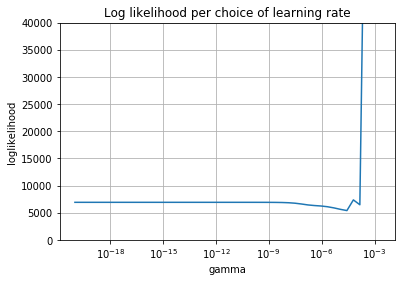

In [44]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
ax.set_ylim([0, 40000])
plt.show()

In [47]:
idx = np.nanargmin(losses_rlr)

loss_rlr = losses_rlr[idx]
w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_rlr, loss=loss_rlr, gamma = gamma_rlr))

w* =[ 0.04708202 -1.19773115 -0.05540163  0.2926052   0.07790406  0.12644402
  0.07219757  0.08316369 -0.11193043  0.07415262  0.05391575  0.11050842
  0.0835273   0.48494284  0.08415142  0.08493845 -0.22901784  0.08419804
  0.08789071 -0.24463026  0.07986618 -0.14444596  0.08498644  0.08326383
 -0.26838121  0.08636396  0.083503   -0.01406704]

loglikelihood loss=5414.027559653283

gamma=2.6826957952797274e-05


***Cross-validation hyperparameter selection***

In [48]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-15, -1, 50)
ratio_train = 0.7
max_iters = 100
seeds = range(20)
degrees = range(0, 20)
initial_w = np.zeros(tX.shape[1])

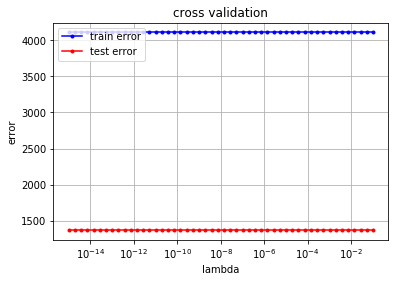

In [49]:
k_indices = build_k_indices(y, k_fold, seed)

loss_tr_cv = []
loss_te_cv = []

for lambda_ in  lambdas:
    log_tr = []
    log_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation_log(y, tX, k_indices, k, lambda_, degree_rlr, initial_w, max_iters, gamma_rlr)
        log_tr.append(loss_tr)
        log_te.append(loss_te)
    loss_tr_cv.append(np.mean(log_tr))
    loss_te_cv.append(np.mean(log_te))
cross_validation_visualization(lambdas, loss_tr_cv, loss_te_cv)

In [50]:
idx = np.nanargmin(loss_te_cv)
lambda_rlr = lambdas[idx]

print("lambda* ={lambda_}\n\nloglikelihood train={log_tr}\n\nloglikelihood test={log_te}".format(
    lambda_=lambda_rlr, log_tr=loss_tr_cv[idx], log_te=loss_te_cv[idx]))

lambda* =1e-15

loglikelihood train=4108.190939763232

loglikelihood test=1371.6501238494548


***Bias-variance decomposition for complexity determination***

In [ ]:
loss_tr_bv = np.empty((len(seeds), len(degrees)))
loss_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        
        
    loss_tr = []
    loss_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
        
        initial_w = np.zeros(tx_tr.shape[1])
        
        w_tr, log_tr = reg_logistic_regression(y_tr, tx_tr, lambda_rlr, initial_w, max_iters, gamma_rlr)
        log_te = compute_loglikelihood(y_te, tx_te, w_tr)
            
        loss_tr_bv[index_seed][index_deg] = log_tr
        loss_tr_bv[index_seed][index_deg] = log_te

bias_variance_decomposition_visualization(degrees, loss_tr_bv, loss_te_bv)

In [ ]:
loss_te_bv = np.array(loss_te_bv)
loss_tr_bv = np.array(loss_tr_bv)

idx = np.nanargmin(np.mean(loss_te_bv-loss_tr_bv, axis=1))

degree_ri = degrees[idx]

print("degree* ={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}".format(
    degree=degree_rlr, loss_tr=loss_tr_bv[idx].mean(), rmse_te=loss_te_bv[idx].mean()))

### Overfitting vs Underfitting

### Methods application and visualization

## Generate predictions and save ouput in csv format for submission:

In [ ]:
weights = w_ls

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../data/sample-submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)